## Load MNIST Dataset
### MNIST Dataset was loaded from Tensorflow package from -- https://www.tensorflow.org/datasets/catalog/mnist
Load the MNIST dataset is downloaded using the tensor flow package, with information in the link above. The link given in the assignment is now password protected, so I pulled it directly from the TensorFlow package instead.

In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def get_mnist_dataset_normalized(num_classes=10):
    """
    Loads the MNIST dataset and normalizes the pixel values to [0, 1]. Also one-hot encodes the labels so it's usable with the training models
    :return: x_train, y_train, x_test, y_test
    """
    num_label_classes = 10  # Number of classes in MNIST, (0-9 digits)
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize pixel values to [0, 1]
    x_train,x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0  
    # One-hot encode the labels
    y_train,y_test = tf.one_hot(y_train, depth=num_classes), tf.one_hot(y_test, depth=num_classes)
    return x_train, y_train, x_test, y_test


## Soft-max Regression Classifier
This section will define method to use the soft-max regression classifier to classify the MNIST dataset.
The classifier will have optional parameters to use or not use dropout, and to use or not use batch normalization.
 #### Parameters
 * Learning Rate: 0.1
 * Batch Size: 100
 * Dropout Rate (when applied): 0.3
 * Training Iterations over the data: 10

In [70]:

class SoftmaxRegressionClassifier:
    def __init__(self, x_train, y_train, x_test, y_test, dropout=False, batch_norm=False):
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        self.output_size = 10
        self.learning_rate = 0.01
        self.batch_size = 250
        self.epochs = 10
        self.input_size = 28 * 28
        self.dropout_rate = 0.2
        # Weights
        self.weights = tf.Variable(tf.random.normal([self.input_size, self.output_size], dtype=tf.float32))
        self.biases = tf.Variable(tf.zeros([self.output_size], dtype=tf.float32))

        # Variable to modify the algorithm
        self.use_dropout = dropout
        self.use_batch_normalization = batch_norm
        # data to keep track of for graphing
        self.train_accuracy_data = []
        self.train_loss_data = []
        self.test_accuracy_data = []

    # Define the softmax function
    def softmax(self, x):
        exp_x = tf.exp(x - tf.reduce_max(x, axis=1, keepdims=True))
        return exp_x / tf.reduce_sum(exp_x, axis=1, keepdims=True)

    def batch_normalization(self, logits):
        """
        Batch normalization layer for training and testing
        :param logits: Logits tensor, [batch_size, num_classes]
        :return: Batch normalization layer
        """
        return tf.compat.v1.layers.BatchNormalization()(logits)

    def dropout(self, logits):
        """
        Dropout layer
        :param logits: Logits tensor, [batch_size, num_classes]
        :return: Dropout layer
        """
        return tf.nn.dropout(logits, rate=self.dropout_rate)

    def internal_accuracy(self, x_batch, y_batch):
        logits = tf.matmul(x_batch, self.weights) + self.biases
        y_pred = tf.nn.softmax(logits)
        y_pred_class = tf.argmax(y_pred, axis=1)
        y_batch_class = tf.argmax(y_batch, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_class, y_batch_class), tf.float32))
        return accuracy

    def external_accuracy(self):
        x_test = tf.reshape(self.x_test, (self.x_test.shape[0], -1))  # Flatten x_test
        x_test = tf.cast(x_test, tf.float32)
        logits = tf.matmul(x_test, self.weights) + self.biases
        y_pred = tf.nn.softmax(logits)
        y_pred_class = tf.argmax(y_pred, axis=1)
        y_test_class = tf.argmax(self.y_test, axis=1)
        test_accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_class, y_test_class), tf.float32))
        return test_accuracy

    def train(self):
        step = 0
        for epoch in range(self.epochs):
            for i in range(0, len(x_train), self.batch_size):
                x_batch = self.x_train[i:i + self.batch_size]
                y_batch = self.y_train[i:i + self.batch_size]

                with tf.GradientTape() as tape:
                    x_batch = tf.cast(x_batch, tf.float32)  # Cast x_batch to float32
                    x_batch = tf.reshape(x_batch, (x_batch.shape[0], -1))  # Flatten x_batch
                    logits = tf.matmul(x_batch, self.weights) + self.biases

                    if self.use_batch_normalization:
                        logits = self.batch_normalization(logits)
                    
                    if self.use_dropout:
                        logits = self.dropout(logits)


                    y_pred = tf.nn.softmax(logits)
                    loss = -tf.reduce_sum(y_batch * tf.math.log(y_pred + 1e-9)) / self.batch_size
                        
                gradients = tape.gradient(loss, [self.weights, self.biases])
                self.weights.assign_sub(self.learning_rate * gradients[0])
                self.biases.assign_sub(self.learning_rate * gradients[1])

                # Evaluate accuracy and loss for each step for the training data
                accuracy = self.internal_accuracy(x_batch, y_batch)
                self.train_accuracy_data.append(accuracy)
                self.train_loss_data.append(loss.numpy())
                # Evaluate the accuracy on the test data at every step
                self.test_accuracy_data.append(self.external_accuracy())

                if step % 1000 == 0:
                    print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {accuracy.numpy():.4f}")
                step += 1
    
    def get_train_data(self):
        return self.train_accuracy_data, self.train_loss_data

    def get_test_data(self):
        return self.test_accuracy_data



In [71]:
x_train, y_train, x_test, y_test = get_mnist_dataset_normalized()

softmax = SoftmaxRegressionClassifier(x_train, y_train, x_test, y_test, False, False)
softmax.train()

softmax_dropout = SoftmaxRegressionClassifier(x_train, y_train, x_test, y_test, True, False)
softmax_dropout.train()

softmax_batch_norm = SoftmaxRegressionClassifier(x_train, y_train, x_test, y_test, False, True)
softmax_batch_norm.train()

Step 0, Loss: 11.7142, Accuracy: 0.1120
Step 1000, Loss: 3.1598, Accuracy: 0.4680
Step 2000, Loss: 2.5807, Accuracy: 0.5600
Step 0, Loss: 13.3551, Accuracy: 0.0920
Step 1000, Loss: 5.4438, Accuracy: 0.3560
Step 2000, Loss: 4.1363, Accuracy: 0.5000
Step 0, Loss: 11.1965, Accuracy: 0.1120
Step 1000, Loss: 3.3918, Accuracy: 0.4240
Step 2000, Loss: 3.2315, Accuracy: 0.5200


#### Graph Accuracy and Loss for the Softmax Comparisons with the following conditions:
1. Without any additional aglorithms
2. With dropout
3. With batch normalization

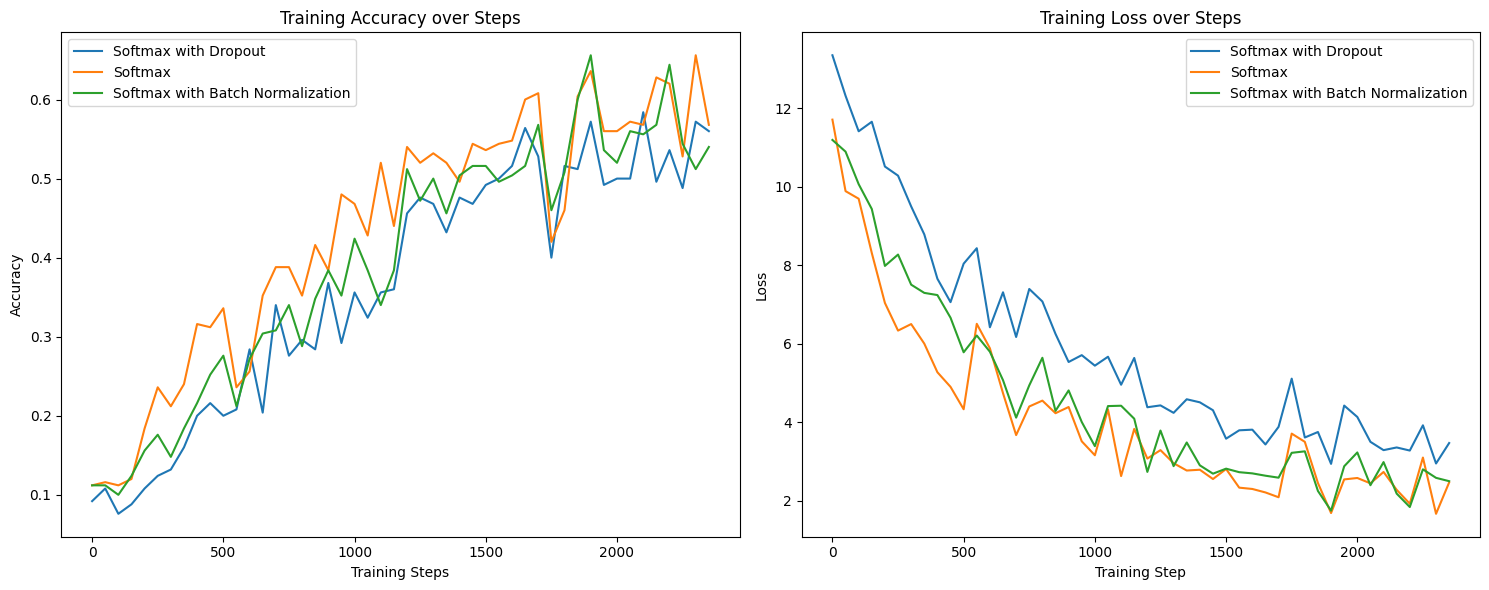

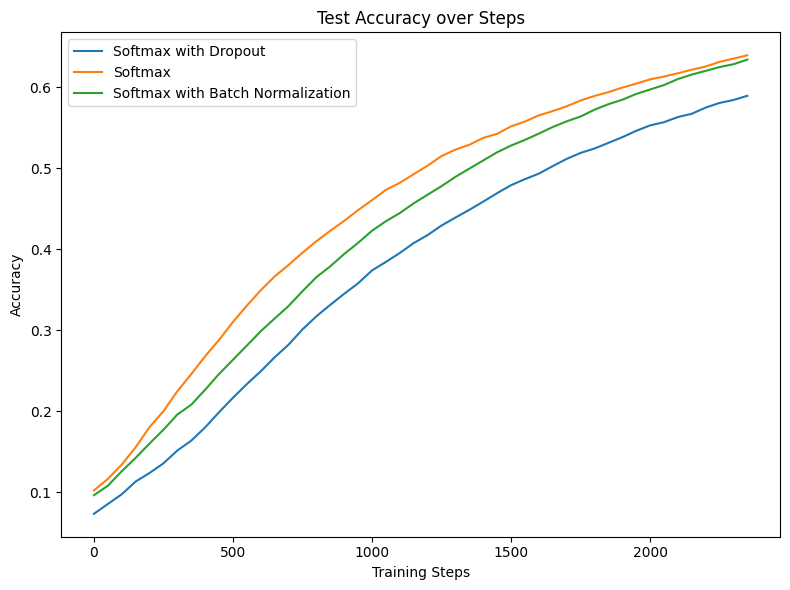

In [72]:
import matplotlib.pyplot as plt

only_graph_every_x_points = 50 # How often to graph, so it doesn't look overly crowded
def skip_points(data_to_skip_over, graph_every_x_points=only_graph_every_x_points):
    """
    Skips every graph_every_x_points points in the data, so it does not look overly crowded
    """
    new_y_data = []
    for i in range(0, len(data_to_skip_over), graph_every_x_points):
        new_y_data.append(data_to_skip_over[i])

    new_x_axis = np.arange(0, len(data_to_skip_over), graph_every_x_points)
    return new_x_axis, new_y_data

def plot_test_data(softmax, softmax_dropout, softmax_batch_norm, graph_every_x_points=only_graph_every_x_points):
    """
    Plots the training data for the three models
    """
    # Softmax
    test_accuracy = softmax.get_test_data()
    test_accuracy_plot_x, test_accuracy_plot_y = skip_points(test_accuracy)
    # Softmax with dropout
    test_accuracy_dropout = softmax_dropout.get_test_data()
    test_accuracy_plot_x_dropout, test_accuracy_plot_y_dropout = skip_points(test_accuracy_dropout)
    # Softmax with batch normalization
    test_accuracy_batch_norm = softmax_batch_norm.get_test_data()
    test_accuracy_plot_x_batch_norm, test_accuracy_plot_y_batch_norm = skip_points(test_accuracy_batch_norm)

    figure2 = plt.figure(figsize=(8, 6))
    subplot1 = plt.subplot(1, 1, 1)

    subplot1.plot(test_accuracy_plot_x_dropout, test_accuracy_plot_y_dropout, label='Softmax with Dropout')
    subplot1.plot(test_accuracy_plot_x, test_accuracy_plot_y, label='Softmax')
    subplot1.plot(test_accuracy_plot_x_batch_norm, test_accuracy_plot_y_batch_norm, label='Softmax with Batch Normalization')
    subplot1.set_xlabel('Training Steps')
    subplot1.set_ylabel('Accuracy')
    subplot1.set_title('Test Accuracy over Steps')
    subplot1.legend()

    plt.tight_layout()
    plt.show()

def plot_training_data(softmax, softmax_dropout, softmax_batch_norm, graph_every_x_points=only_graph_every_x_points):
    # Softmax
    train_accuracy, loss_data = softmax.get_train_data()
    train_accuracy_plot_x, train_accuracy_plot_y = skip_points(train_accuracy)
    trani_loss_plot_x, train_loss_plot_y = skip_points(loss_data)
    # Softmax with dropout
    train_accuracy_dropout, loss_data_dropout = softmax_dropout.get_train_data()
    train_accuracy_plot_x_dropout, train_accuracy_plot_y_dropout = skip_points(train_accuracy_dropout)
    train_loss_plot_x_dropout, train_loss_plot_y_dropout = skip_points(loss_data_dropout)
    # Softmax with batch normalization
    train_accuracy_batch_norm, loss_data_batch_norm = softmax_batch_norm.get_train_data()
    train_accuracy_plot_x_batch_norm, train_accuracy_plot_y_batch_norm = skip_points(train_accuracy_batch_norm)
    train_loss_plot_x_batch_norm, train_loss_plot_y_batch_norm = skip_points(loss_data_batch_norm)

    figure1 = plt.figure(figsize=(15, 6))

    subplot1 = plt.subplot(1, 2, 1)

    subplot1.plot(train_accuracy_plot_x_dropout, train_accuracy_plot_y_dropout, label='Softmax with Dropout')
    subplot1.plot(train_accuracy_plot_x, train_accuracy_plot_y, label='Softmax')
    subplot1.plot(train_accuracy_plot_x_batch_norm, train_accuracy_plot_y_batch_norm, label='Softmax with Batch Normalization')
    subplot1.set_xlabel('Training Steps')
    subplot1.set_ylabel('Accuracy')
    subplot1.set_title('Training Accuracy over Steps')
    subplot1.legend()

    subplot2 = plt.subplot(1, 2, 2)
    subplot2.plot(train_loss_plot_x_dropout, train_loss_plot_y_dropout, label='Softmax with Dropout')
    subplot2.plot(trani_loss_plot_x, train_loss_plot_y, label='Softmax')
    subplot2.plot(train_loss_plot_x_batch_norm, train_loss_plot_y_batch_norm, label='Softmax with Batch Normalization')
    subplot2.set_xlabel('Training Step')
    subplot2.set_ylabel('Loss')
    subplot2.set_title('Training Loss over Steps')
    subplot2.legend()

    plt.tight_layout()
    plt.show()


plot_training_data(softmax, softmax_dropout, softmax_batch_norm)
plot_test_data(softmax, softmax_dropout, softmax_batch_norm)

# MLP

In [96]:
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist

class MultiLayerPerception():
    def __init__(self, x_data, y_data, x_test, y_test, dropout=False, batch_norm=False):
        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        self.use_dropout, self.use_batch_norm = dropout, batch_norm
        self.num_classes = 10
        self.dropout_rate = 0.2
        self.epochs = 10
        self.input_shape = (28, 28)
        self.mlp_model = self.create_model(self.input_shape, dropout, batch_norm)
        # Create lists to store loss and accuracy
        self.loss_history = []
        self.accuracy_history = []

    def create_model(self, input_shape, dropout, batch_norm):
        model = Sequential()
        model.add(Flatten(input_shape=(28, 28)))

        # First hidden layer
        model.add(Dense(128, activation='relu'))
        if self.use_batch_norm:
            model.add(BatchNormalization())
        if self.use_dropout:
            model.add(Dropout(0.2))

        # Second hidden layer
        model.add(Dense(64, activation='relu'))
        if self.use_batch_norm:
            model.add(BatchNormalization())
        if self.use_dropout:
            model.add(Dropout(0.2))

        # Output layer
        model.add(Dense(10, activation='softmax'))
        return model

    def train(self, batch_size=100):
        self.mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        # Training loop
        for epoch in range(self.epochs):
            history = model.fit(x_train, y_train, epochs=1, batch_size=100, verbose=0)
            loss_history.append(history.history['loss'][0])
            accuracy_history.append(history.history['accuracy'][0])

    def get_train_data(self):
        return self.accuracy_history, self.loss_history
        


In [97]:
x_train, y_train, x_test, y_test = get_mnist_dataset_normalized()
mlp = MultiLayerPerception(x_train, y_train, x_test, y_test, False, False)
mlp.train()
train_accuracy, loss_data = mlp.get_train_data()

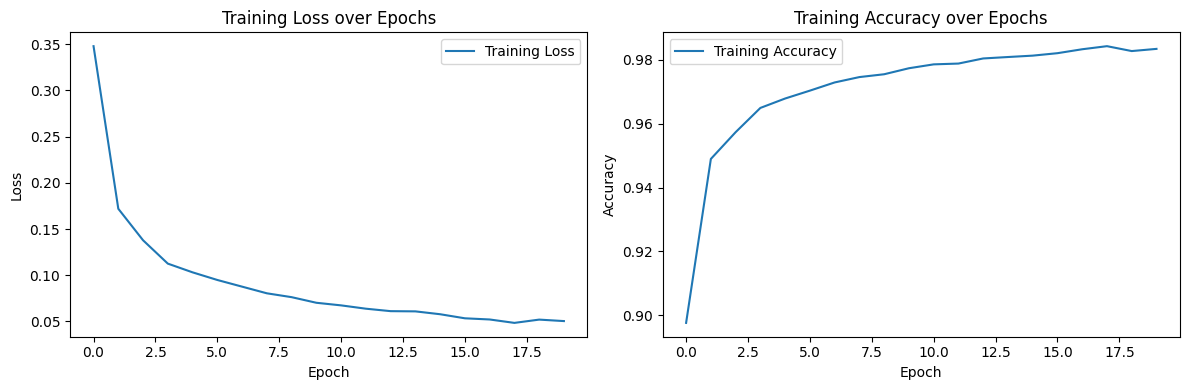

In [95]:


# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(20), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(20), accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# CNN

In [63]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0  # Normalize pixel values to [0, 1

# Expand dimensions for compatibility with CNN
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Convert class labels to one-hot encoded tensors
num_classes = 10
y_train = tf.one_hot(y_train, depth=num_classes)
y_test = tf.one_hot(y_test, depth=num_classes)

# Define the CNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/10
938/938 [==============================] - 9s 9ms/step - loss: 0.2365 - accuracy: 0.9291
Epoch 2/10
281/938 [=======>......................] - ETA: 6s - loss: 0.0965 - accuracy: 0.9721

KeyboardInterrupt: 

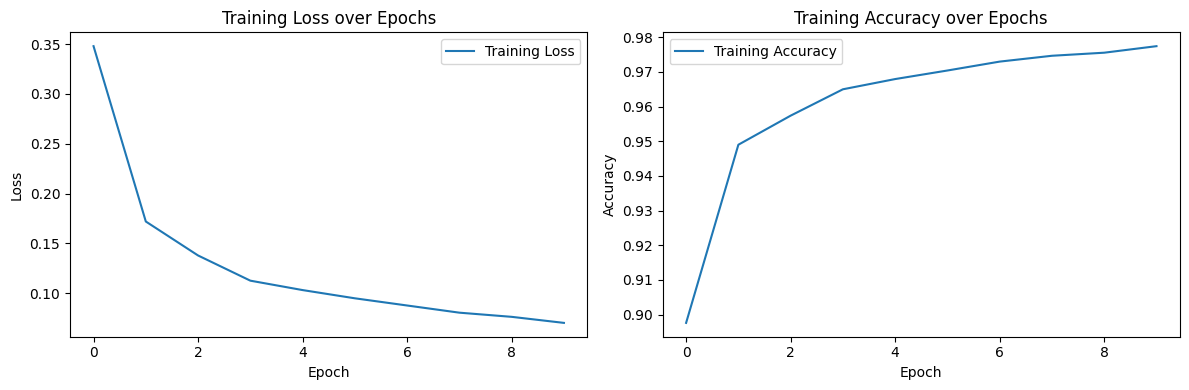

In [88]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to [0, 1]

# Convert class labels to one-hot encoded tensors
num_classes = 10
y_train = tf.one_hot(y_train, depth=num_classes)
y_test = tf.one_hot(y_test, depth=num_classes)

# Define the MLP model with optional batch normalization and dropout
def create_mlp_model(use_batch_norm=False, use_dropout=False):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # First hidden layer
    model.add(Dense(128, activation='relu'))
    if use_batch_norm:
        model.add(BatchNormalization())
    if use_dropout:
        model.add(Dropout(0.2))

    # Second hidden layer
    model.add(Dense(64, activation='relu'))
    if use_batch_norm:
        model.add(BatchNormalization())
    if use_dropout:
        model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(10, activation='softmax'))
    return model

# Compile the model
model = create_mlp_model(use_batch_norm=True, use_dropout=True)  # Set flags as needed

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create lists to store loss and accuracy
loss_history = []
accuracy_history = []

# Training loop
epochs = 10
for epoch in range(epochs):
    history = model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=0)
    loss_history.append(history.history['loss'][0])
    accuracy_history.append(history.history['accuracy'][0])

# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()